In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-nonlineqn-secant)=
# Interpolation-based methods

From a practical standpoint, one of the biggest drawbacks of Newton's method is the requirement to supply $f'$ in {numref}`Function {number} <function-newton>`. It is both a programming inconvenience and a step that requires computational time. We can avoid using $f'$, however, by making a simple but easily overlooked observation:

```{proof:observation}
 When a step produces an approximate result, you are free to carry it out approximately. 
```

Let's call this the *principle of approximate approximation.*

In the Newton context, the principle of approximate approximation begins with the observation that the use of $f'$ is linked to the construction of a linear approximation $q(x)$ equivalent to a tangent line. The root of $q(x)$ is used to define the next iterate in the sequence. We can avoid calculating the value of $f'$ by choosing a different linear approximation.

(demo-secant-line)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We return to finding a root of the equation $x e^x=2$.

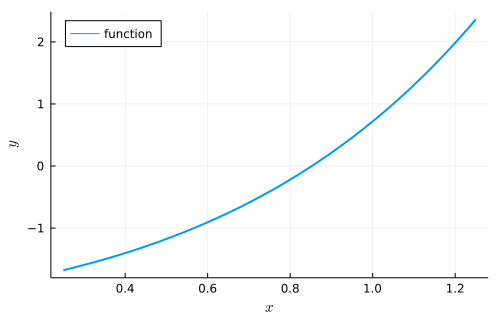

In [2]:
f = x -> x*exp(x) - 2;

plot(f,0.25,1.25,label="function",
    xlabel=L"x",ylabel=L"y",legend=:topleft)

From the graph, it's clear that there is a root near $x=1$. To be more precise, there is a root in the interval $[0.5,1]$. So let us take the endpoints of that interval as _two_ initial approximations.

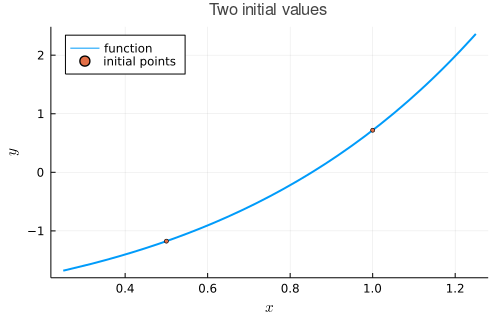

In [3]:
x₁ = 1;    y₁ = f(x₁);
x₂ = 0.5;  y₂ = f(x₂);
scatter!([x₁,x₂],[y₁,y₂],label="initial points",
    title="Two initial values")

Instead of constructing the tangent line by evaluating the derivative, we can construct a linear model function by drawing the line between the two points $\bigl(x_1,f(x_1)\bigr)$ and $\bigl(x_2,f(x_2)\bigr)$. This is called a _secant line_.

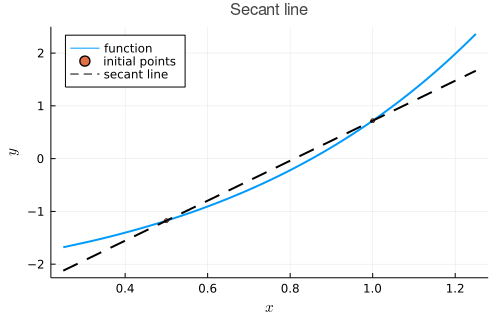

In [4]:
m₂ = (y₂-y₁) / (x₂-x₁)
secant = x -> y₂ + m₂*(x-x₂)
plot!(secant,0.25,1.25,label="secant line",l=:dash,color=:black,
    title="Secant line")

As before, the next root estimate in the iteration is the root of this linear model.

y₃ = f(x₃) = -0.17768144843679456


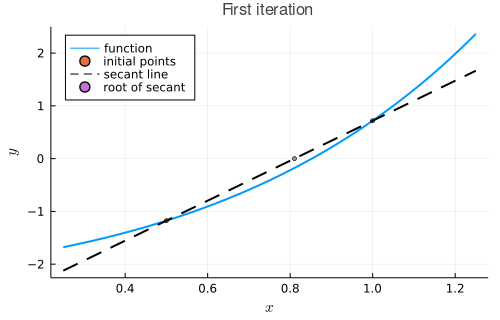

In [5]:
x₃ = x₂ - y₂/m₂
@show y₃ = f(x₃)
scatter!([x₃],[0],label="root of secant",title="First iteration")

For the next linear model, we use the line through the two most recent points. The next iterate is the root of that secant line, and so on.

In [6]:
m₃ = (y₃-y₂) / (x₃-x₂)
x₄ = x₃ - y₃/m₃

0.8656319273409482

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

The example in {numref}`Demo %s <demo-secant-line>` demonstrates the **secant method**. In the secant method, one finds the root of the linear approximation through the two most recent root estimates. That is, given previous approximations $x_1,\ldots,x_k$, define the linear model function as the line through $\bigl(x_{k-1},f(x_{k-1})\bigr)$ and $\bigl(x_k,f(x_k)\bigr)$:

```{math}
:label: secantmodel
q(x) = f(x_k) + \frac{f(x_k)-f(x_{k-1})}{x_k-x_{k-1}}(x-x_k).
```

Solving $q(x_{k+1})=0$ for $x_{k+1}$ gives the iteration formula.

```{index} ! secant method
```

:::{proof:algorithm} Secant iteration
Given function $f$ and two initial values $x_1$ and $x_2$, define
```{math}
:label: secant
x_{k+1} = x_k - \frac{f(x_k)(x_k-x_{k-1})}{f(x_k)-f(x_{k-1})}, \quad k=2,3,\ldots.
```
:::

Our implementation of the secant method is given in {numref}`Function {number} <function-secant>`.

(function-secant)=

```{proof:function} secant
**Secant method for scalar rootfinding**

```{code-block} julia1
:lineno-start: 1
"""
    secant(f,x₁,x₂[;maxiter,ftol,xtol])

Use the secant method to find a root of `f` starting from `x₁` and
`x₂`. Returns a vector of root estimates.

The optional keyword parameters set the maximum number of iterations
and the stopping tolerance for values of `f` and changes in `x`.
"""
function secant(f,x₁,x₂;maxiter=40,ftol=100*eps(),xtol=100*eps())
    x = [float(x₁),float(x₂)]
    y₁ = f(x₁)
    Δx,y₂ = Inf,Inf   # for initial pass in the loop below
    k = 2

    while (abs(Δx) > xtol) && (abs(y₂) > ftol) 
        y₂ = f(x[k])
        Δx = -y₂ * (x[k]-x[k-1]) / (y₂-y₁)   # secant step
        push!(x,x[k]+Δx)        # append new estimate

        k += 1
        y₁ = y₂    # current f-value becomes the old one next time
        
        if k==maxiter
            @warn "Maximum number of iterations reached."
            break   # exit loop
        end
    end
    return x
end
```

```{admonition} About the code
:class: dropdown
Because we want to observe the convergence of the method, {numref}`Function {number} <function-secant>` stores and returns the entire sequence of root estimates. However, only the most recent two are needed by the iterative formula. This is demonstrated by the use of `y₁` and `y₂` for the two most recent values of $f$.
```

## Convergence

Graphically, a secant line usually looks like a less accurate model of $f$ than the tangent line. How will that affect the convergence? 

As before, let $\epsilon_k = x_k-r$ be the errors in the successive root approximations, and assume that $r$ is a simple root. If the initial errors are small, then a tedious but straightforward Taylor expansion shows that, to lowest order,

```{math}
:label: secanterr
\epsilon_{k+1} \approx \frac{1}{2}\frac{f''(r)}{f'(r)} \epsilon_k \epsilon_{k-1}.
```

If we make an educated guess that

```{math}
\epsilon_{k+1} = c (\epsilon_k)^\alpha, \quad \epsilon_k = c (\epsilon_{k-1})^\alpha, \ldots, \qquad \alpha>0,
```

then {eq}`secanterr` becomes

```{math}
:label: secantexponents
\left[ \epsilon_{k-1}^{\alpha} \right]^{\,\alpha} \approx C \epsilon_{k-1}^{\alpha+1}
```

for an unknown constant $C$. Treating the approximation as an equality, this becomes solvable if and only if the exponents match, i.e., $\alpha^2 = \alpha+1$. The only positive root of this equation is the golden ratio,

```{math}
  \alpha = \frac{1+\sqrt{5}}{2} \approx 1.618.
```

```{index} ! superlinear convergence
```

```{index} ! convergence rate; superlinear
```

Hence the errors in the secant method converge like $\epsilon_{k+1} = c (\epsilon_k)^\alpha$  for $1<\alpha<2$.

::::{proof:definition} Superlinear convergence
Suppose a sequence $x_k$ approaches limit $x^*$. If the error sequence $\epsilon_k=x_k - x^*$ satisfies

```{math}
  :label: superlinear-convergence
  \lim_{k\to\infty} \frac{|\epsilon_{k+1}|}{|\epsilon_k|^\alpha} = L
```

for constants $\alpha >1$ and $L>0$, then the sequence has **superlinear convergence** with rate $\alpha$. 
::::

Quadratic convergence is a particular case of superlinear convergence. Roughly speaking, we expect

```{math}
:label: superlinear-rate
\log |\epsilon_{k+1}| & \approx \alpha (\log |\epsilon_k|) + \log L, \\ 
\frac{\log |\epsilon_{k+1}|}{\log |\epsilon_k|} & \approx \alpha + \frac{\log L}{\log |\epsilon_k|} \to \alpha,
```

as $k\to\infty$.

(demo-secant-converge)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We check the convergence of the secant method from {numref}`Demo %s <demo-secant-line>`. Again we will use extended precision to get a longer sequence than double precision allows.

In [7]:
f = x -> x*exp(x) - 2
x = FNC.secant(f,BigFloat(1),BigFloat(0.5),xtol=1e-80,ftol=1e-80);

We don't know the exact root, so we use the last value as a proxy.

In [8]:
r = x[end]

0.8526055020137254913464724146953174668984533001514035087721073946525150656742605

Here is the sequence of errors.

In [9]:
ϵ = @. Float64(r - x[1:end-1])

12-element Vector{Float64}:
 -0.14739449798627452
  0.3526055020137255
  0.04223372706144885
 -0.013026425327222755
  0.00042747994131549927
  4.269915586133851e-6
 -1.4054770126368277e-9
  4.620323656624992e-15
  4.999480931132388e-24
 -1.7783862252641536e-38
  6.845099610444838e-62
  0.0

It's not easy to see the convergence rate by staring at these numbers. We can use {eq}`superlinear-rate` to try to expose the superlinear convergence rate.

In [10]:
[ log(abs(ϵ[k+1])) / log(abs(ϵ[k])) for k in 1:length(ϵ)-1 ]

11-element Vector{Float64}:
  0.5444386280277932
  3.0358017547194556
  1.3716940021941466
  1.7871469297607543
  1.5937804750546951
  1.6485786749732587
  1.6194128077496301
  1.6254302470561015
  1.6200958015239788
  1.6202559600872728
 Inf

As expected, this settles in at around 1.618.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


In terms of the error as a function of the iteration number $k$, the secant method converges at a rate strictly between linear and quadratic, which is slower than Newton's method. But error versus iteration count may not be the best means of comparison.

Often we analyze rootfinding methods by assuming that the bulk of computing time is spent evaluating the user-defined functions $f$ and $f'$. (Our simple examples and exercises mostly don't support this assumption, but many practical applications do.) In this light, we see that Newton's method requires two evaluations, $f(x_k)$ and $f'(x_k)$, for each iteration. The secant method, on the other hand, while it *uses* the two function values $f(x_k)$ and $f(x_{k-1})$ at each iteration, only needs to *compute* a single new one. Note that {numref}`Function {number} <function-secant>` keeps track of one previous function value rather than recomputing it.

Now suppose that $|\epsilon_k|=\delta$. Roughly speaking, two units of work (i.e., function evaluations) in Newton's method brings us to an error of $\delta^2$. If one spreads out the improvement in the error evenly across the two steps, using

```{math}
\delta^2 = \bigl( \delta^{\sqrt{2}} \bigr)^{\!\sqrt{2}},
```

it seems reasonable to say that the rate of convergence in Newton *per function evaluation* is $\sqrt{2}\approx 1.41$. This is actually less than the comparable rate of about $1.62$ for the secant method. 

```{proof:observation}
If function evaluations are used to measure computational work, the secant iteration converges more rapidly than Newton's method.
```

Not only is the secant method easier to apply than Newton's method in practice, it's also more efficient—a rare win-win!

## Inverse interpolation

```{index} interpolation; by polynomials
```

At each iteration, the secant method constructs a linear model function that interpolates the two most recently found points on the graph of $f$. Two points determine a straight line, so this seems like a sensible choice. But as the iteration progresses, why use only the *two* most recent points? What would it mean to use more of them?

If we interpolate through three points by a polynomial, we get a unique quadratic function. Unfortunately, a parabola may have zero, one, or two crossings of the $x$-axis, potentially leaving some doubt as to how to define the next root estimate. On the other hand, if we turn a parabola on its side, we get a graph that intersects the $x$-axis exactly once, which is ideal for defining the next root estimate.

This leads to the idea of defining $q(y)$ as the quadratic interpolant to the points $(y_{k-2},x_{k-2})$, $(y_{k-1},x_{k-1})$, and $(y_k,x_k)$, where $y_i=f(x_i)$ for all $i$, and setting $x_{k+1}=q(0)$. The process defined in this way (given three initial estimates) is called **inverse quadratic interpolation**. Rather than deriving lengthy formulas for it here, we demonstrate how to perform inverse quadratic interpolation using `fit` to perform the interpolation step.

(demo-secant-iqi)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Here we look for a root of $x+\cos(10x)$ that is close to 1.

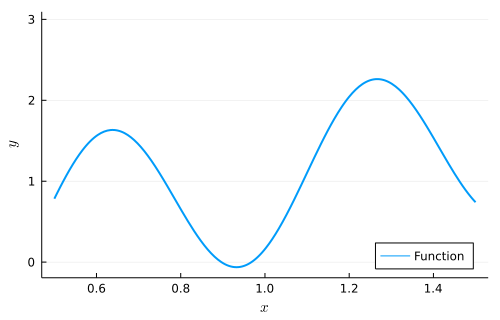

In [11]:
f = x -> x + cos(10*x)
interval = [0.5,1.5]

plot(f,interval...,label="Function",legend=:bottomright,
    grid=:y,ylim=[-.1,3],xlabel=L"x",ylabel=L"y")

We choose three values to get the iteration started.

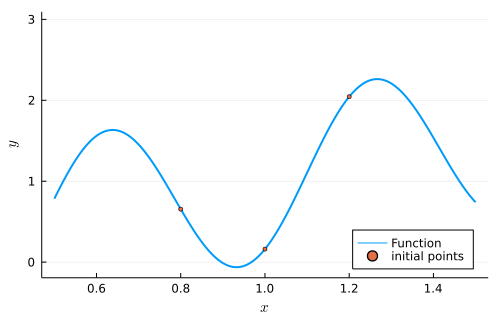

In [12]:
x = [0.8,1.2,1]
y = @. f(x)
scatter!(x,y,label="initial points")

If we were using forward interpolation, we would ask for the polynomial interpolant of $y$ as a function of $x$. But that parabola has no real roots.

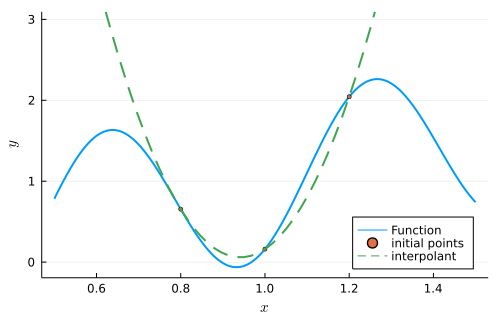

In [13]:
q = Polynomials.fit(x,y,2)      # interpolating polynomial
plot!(x->q(x),interval...,l=:dash,label="interpolant")

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
To do inverse interpolation, we swap the roles of $x$ and $y$ in the interpolation.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
By giving two functions in the plot call, we get the parametric plot $(q(y),y)$ as a function of $y$.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

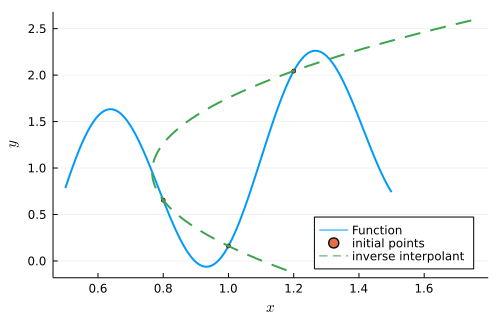

In [14]:
plot(f,interval...,label="Function",
    legend=:bottomright,grid=:y,xlabel=L"x",ylabel=L"y")
scatter!(x,y,label="initial points")

q = Polynomials.fit(y,x,2)       # interpolating polynomial
plot!(y->q(y),y->y,-.1,2.6,l=:dash,label="inverse interpolant")

We seek the value of $x$ that makes $y$ zero. This means evaluating $q$ at zero.

In [15]:
q(0)

1.1039813854404716

Let's restart the process with `BigFloat` numbers to get a convergent sequence.

In [16]:
x = BigFloat.([8,12,10])/10
y = @. f(x)

for k = 3:12
    q = Polynomials.fit(y[k-2:k],x[k-2:k],2)
    push!(x,q(0))
    push!(y,f(x[k+1]))
end

println("residual = $(f(x[end]))")

residual = 0.0


As far as our current precision is concerned, we have an exact root.

In [17]:
r = x[end]
logerr = @. log( Float64(abs(r-x[1:end-1])) )
[ logerr[k+1] / logerr[k] for k in 1:length(logerr)-1 ]

11-element Vector{Float64}:
 0.8184775439869308
 2.3542970902630502
 0.5800188694771786
 2.0942526256516327
 1.3702985897248254
 1.341928284555126
 1.559223884763117
 1.6273137702484697
 1.7028211148950665
 1.7682563502251156
 1.7959111227488174

The convergence is probably superlinear at a rate of $\alpha=1.8$ or greater.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Bracketing

Like Newton's method, the secant and inverse quadratic interpolation methods cannot guarantee convergence. One final new idea is needed to make a (nearly) foolproof algorithm.

If $f$ is continuous on the interval $[a,b]$ and $f(a)f(b)<0$—that is, $f$ changes sign on the interval—then $f$ must have at least one root in the interval, due to the Intermediate Value Theorem from calculus. If we come up with a new root estimate $c\in(a,b)$, then whatever sign $f(c)$ is, it is different from the sign at one of the endpoints. (Of course, if $f(c)$ is zero, we are done!) So either $[a,c]$ or $[c,b]$ is guaranteed to have a root too, and in this way we can maintain not just individual estimates but an interval that always contains a root.

The best algorithms blend the use of fast-converging methods with the guarantee provided by a bracket. For example, say that an iteration begins with a bracketing interval. Make a list of the inverse quadratic estimate, the secant estimate, and the midpoint of the current interval, and pick the first member of the list that lies within the current interval. Replace the interval with the bracketing subinterval, and start a new iteration. This is the idea behind **Brent's method**, which is a very successful rootfinding algorithm.

## Exercises

For each of Exercises 1–3, do the following steps.
  
**(a)** ✍ Rewrite the equation into the standard form for rootfinding, $f(x) = 0$. 

**(b)** ⌨ Make a plot of $f$ over the given interval and determine how many roots lie in the interval. 

**(c)** ⌨ Use `nlsolve` with `ftol=1e-15` to find a reference value for each root. 

**(d)** ⌨ Determine a bracketing interval for each root. Then use {numref}`Function {number} <function-secant>`, starting with the endpoints of the bracketing interval, to find each root.

**(e)** ⌨ For one of the roots, use the errors in the Newton sequence to determine numerically whether the convergence is apparently between linear and quadratic.

1. $x^2=e^{-x}$, over $[-2,2]$

2. $2x = \tan x$, over $[-0.2,1.4]$

3. $e^{x+1}=2+x$, over $[-2,2]$

    ---

4. ⌨ Use a plot to approximately locate all the roots of $f(x)=x^{-2}-\sin(x)$ in the interval $[0.5,10]$. Then find a pair of initial points for each root such that {numref}`Function {number} <function-secant>` converges to that root.

5. ✍ Show analytically that the secant method converges in one step for a linear function, regardless of the initialization.

6. ✍ In general, the secant method formula {eq}`secant` cannot be applied if $x_{k}=x_{k-1}$. However, suppose that $f(x)=ax^2+bx+c$ for constants $a$, $b$, and $c$. Show that in this case the formula can be simplified to one that is well defined when $x_{k}=x_{k-1}$. Then show that the resulting $x_{k+1}$ is the same as the result of one step of Newton's method applied to $f$ at $x_k$.

7. ✍ Let $f(x)=x^2$. Show that if $(1/x_1)$ and $(1/x_2)$ are positive integers, and the secant iteration is applied, then the sequence $1/x_1,1/x_2,1/x_3,\ldots$ is a Fibonacci sequence, i.e., satisfying $x_{k+1}=x_k+x_{k-1}$.

8. ✍ Provide the details that show how to derive {eq}`secanterr` from {eq}`secant`.

9.  ⌨ Write a function `iqi(f,x₁,x₂,x₃)` that performs inverse quadratic interpolation for finding a root of $f$, given three initial estimates. To find the quadratic polynomial $q(y)$ passing through the three most recent points, use `fit`. Test your function on the function in Exercise 1 from this section.